In [1]:
from fastai.vision.all import *
import imageio as iio
import pandas as pd

In [2]:
datadir = Path('/mnt/')
imgdir = Path('/scratch/train_images')
df_train = pd.read_csv(datadir/'train.csv')

In [3]:
df_small = df_train.sample(100)

In [4]:
# img_id = df_small['image_id'].iloc[0]
img_id = '3790f55cad63053e956fb73027179707'
tiff_file = imgdir/f'{img_id}.tiff'

In [5]:
import tifffile

In [6]:
img = tifffile.imread(tiff_file, key=1)

In [7]:
img.shape

(7936, 6400, 3)

In [8]:
tile_size = 250
crop = np.array(img.shape) // tile_size * tile_size; crop

array([7750, 6250,    0])

In [9]:
imgc = img[:crop[0],:crop[1]]
imgc = imgc.reshape(imgc.shape[0] // tile_size, tile_size, imgc.shape[1] // tile_size, tile_size, 3)

In [10]:
imgc.shape

(31, 250, 25, 250, 3)

In [11]:
tiff_file

Path('/scratch/train_images/3790f55cad63053e956fb73027179707.tiff')

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 775.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([254.5 , 254.55, 254.6 , 254.65, 254.7 , 254.75, 254.8 , 254.85,
        254.9 , 254.95, 255.  , 255.05, 255.1 , 255.15, 255.2 , 255.25,
        255.3 , 255.35, 255.4 , 255.45, 255.5 ]),
 <BarContainer object of 20 artists>)

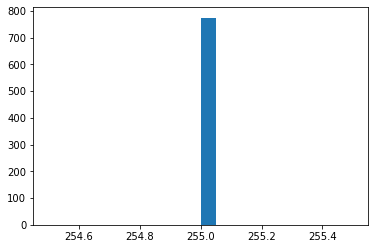

In [12]:
plt.hist(imgc.mean(axis=1).mean(axis=2).mean(axis=-1).reshape(-1), bins=20)

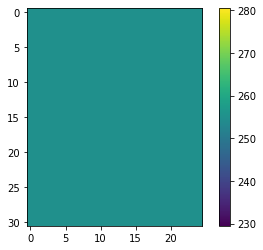

In [13]:
plt.imshow(imgc.mean(axis=1).mean(axis=2).mean(axis=-1))
plt.colorbar()

In [14]:
xs, ys = (imgc.mean(axis=1).mean(axis=2).mean(axis=-1) < 250).nonzero()
if len(xs) == 0:
    xs, ys = (imgc.mean(axis=1).mean(axis=2).mean(axis=-1)).nonzero()

In [15]:
len(xs)

775

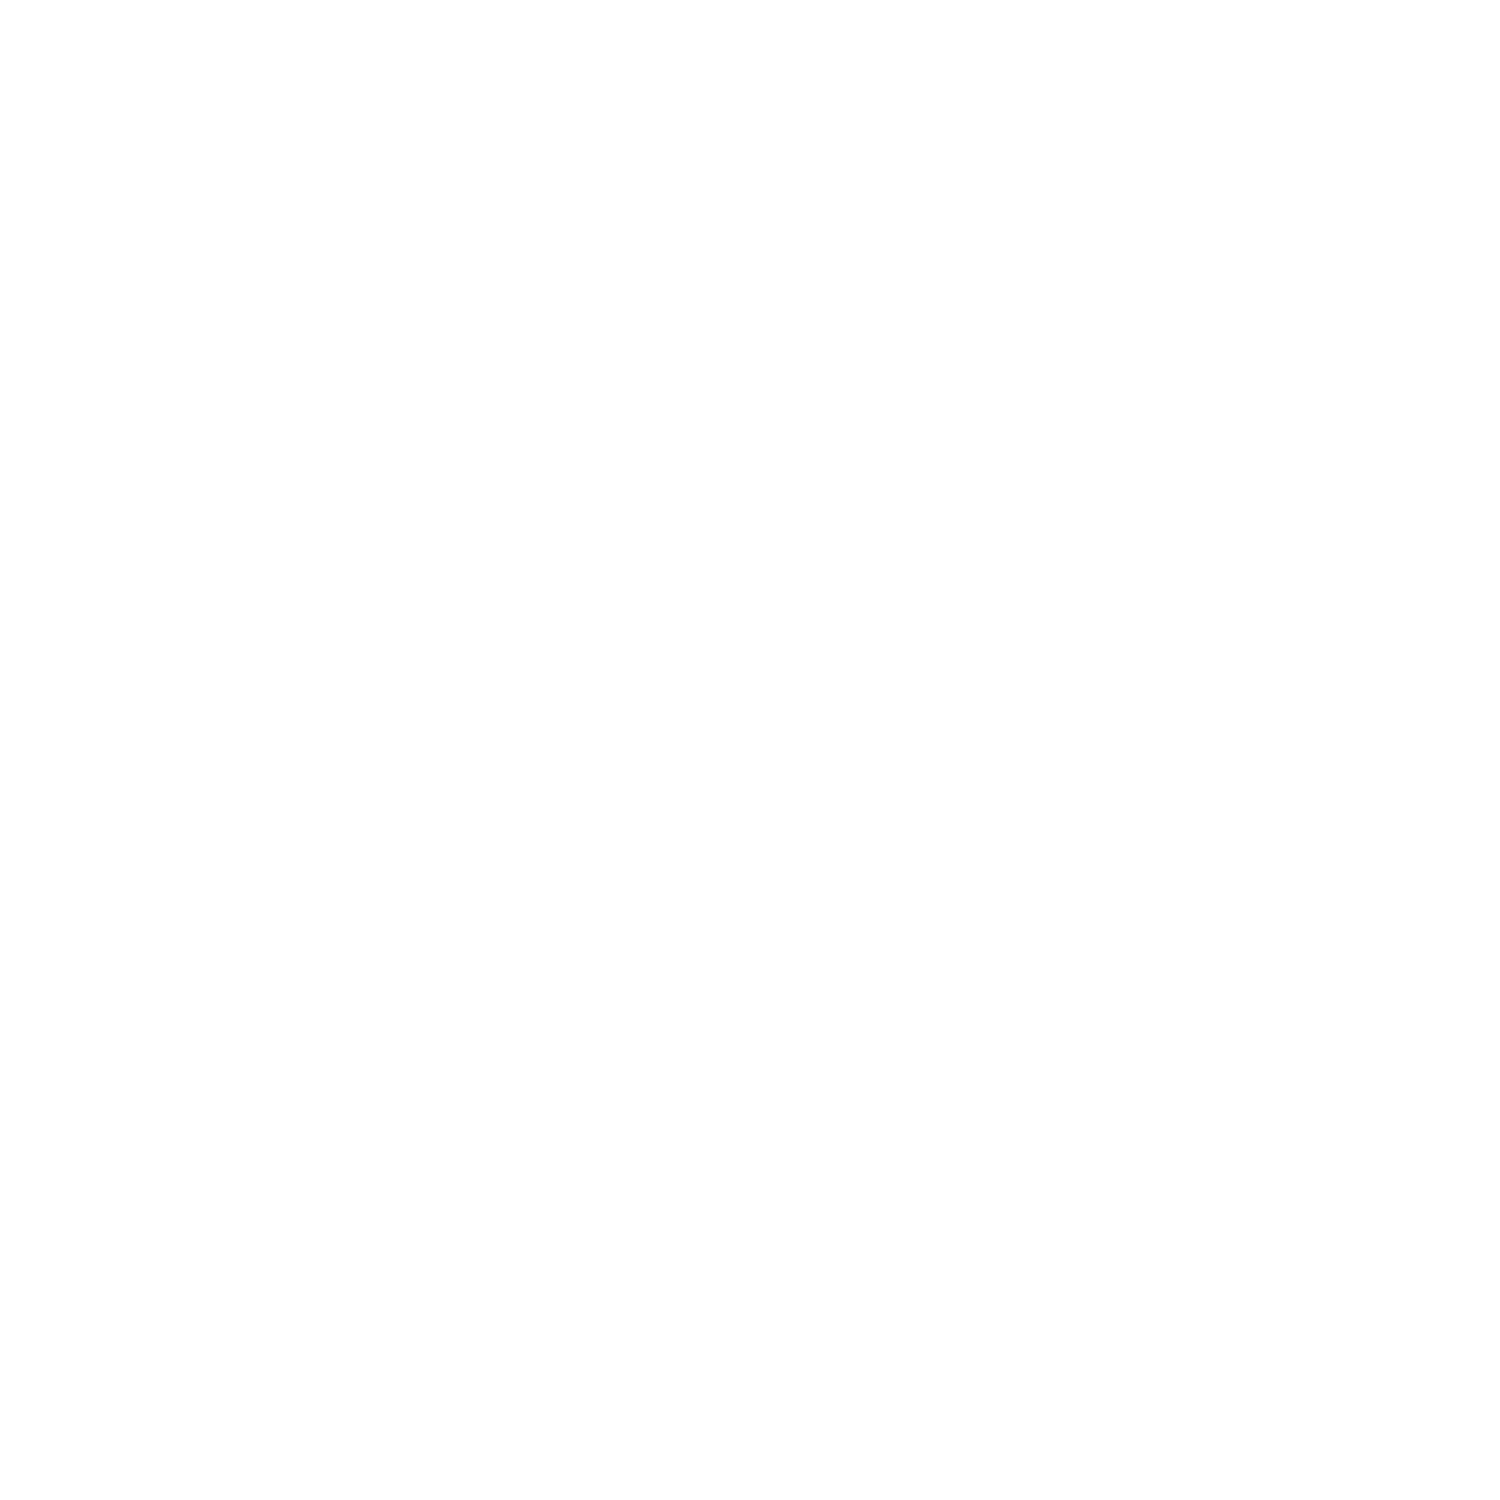

In [16]:
pidxs = random.choices(range(len(xs)), k=36)
PILImage.create(imgc[xs[pidxs],:,ys[pidxs],:].reshape(6,6,tile_size,tile_size,3).transpose(0,2,1,3,4).reshape(6*tile_size,6*tile_size,3))

In [17]:
def get_crops(x):
    tile_size = 250
    tiff_file = imgdir/f'{x["image_id"]}.tiff'
    img = tifffile.imread(tiff_file, key=1)
    crop = np.array(img.shape) // tile_size * tile_size; crop
    imgc = img[:crop[0],:crop[1]]
    imgc = imgc.reshape(imgc.shape[0] // tile_size, tile_size, imgc.shape[1] // tile_size, tile_size, 3)
    xs, ys = (imgc.mean(axis=1).mean(axis=2).mean(axis=-1) < 252).nonzero()
    if len(xs) == 0:
        xs, ys = (imgc.mean(axis=1).mean(axis=2).mean(axis=-1)).nonzero()
#     if len(xs) < 2: print("no data in image:", x)
    pidxs = random.choices(list(range(len(xs))), k=36)
    return PILImage.create(imgc[xs[pidxs],:,ys[pidxs],:].reshape(6,6,tile_size,tile_size,3).transpose(0,2,1,3,4).reshape(6*tile_size,6*tile_size,3))
#     return imgc.mean(axis=1).mean(axis=2).mean(axis=-1)

In [18]:
%prun get_crops(df_train.iloc[0])

In [19]:
df_train.iloc[0]

image_id         0005f7aaab2800f6170c399693a96917
data_provider                          karolinska
isup_grade                                      0
gleason_score                                 0+0
Name: 0, dtype: object

In [20]:
def get_labels(x):
    return np.arange(5) <= x['isup_grade']

In [21]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=[f'isup{i}' for i in range(5)])),
    splitter=RandomSplitter(),
    get_x=get_crops,
    get_y=get_labels,
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()]
)

In [22]:
dls = dblock.dataloaders(df_train)

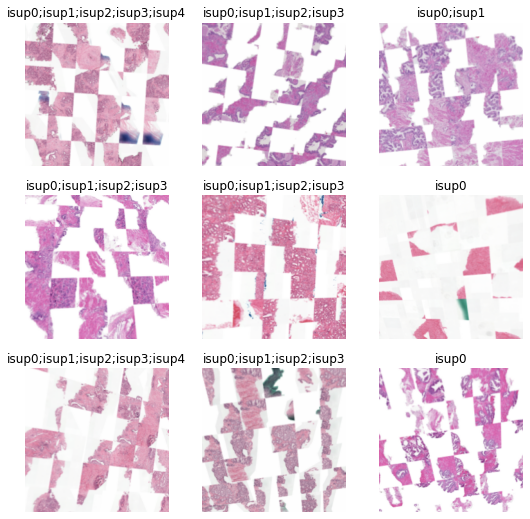

In [23]:
dls.show_batch()

In [24]:
learn = vision_learner(dls, resnet18, metrics=accuracy_multi, pretrained=True)

SuggestedLRs(valley=0.0020892962347716093)

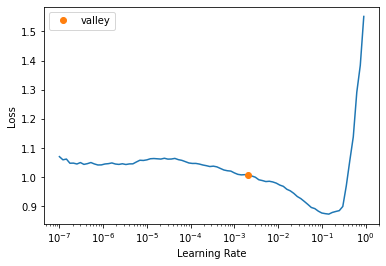

In [25]:
learn.lr_find()

In [27]:
learn = vision_learner(dls, resnet18, metrics=accuracy_multi, pretrained=True)

In [26]:
learn.fine_tune(10, 5e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.586116,0.438427,0.781347,06:53


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.407527,0.464973,0.790391,06:51
1,0.378727,0.426012,0.801696,06:50
2,0.372889,0.403132,0.796609,06:50
3,0.357856,0.342520,0.839001,06:50
4,0.352649,0.362229,0.826849,06:49
5,0.346437,0.346925,0.837965,06:49
6,0.336075,0.331800,0.841262,06:47
7,0.326002,0.343816,0.837871,06:49
8,0.319828,0.351854,0.832407,06:47
9,0.313144,0.340698,0.840791,06:49


In [28]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.596322,0.608544,0.731512,06:47
1,0.415303,0.457695,0.790862,06:46
2,0.385843,0.401575,0.806406,06:47
3,0.361729,0.403461,0.801036,06:46
4,0.356290,0.436885,0.794254,06:47


In [30]:
learn.save('panda-model-1')

Path('models/panda-model-1.pth')

In [109]:
learn = vision_learner(dls, resnet18, metrics=accuracy_multi, pretrained=False)
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.806250,0.903598,0.582007,04:01
1,0.575439,0.994854,0.668205,04:02
2,0.492601,0.457235,0.766934,04:06
3,0.456506,2.686543,0.551295,04:03
4,0.445834,0.449718,0.774376,04:04
5,0.427653,0.846616,0.683090,04:05
6,0.411711,0.464807,0.777956,04:02
7,0.400866,0.642778,0.652661,04:04
8,0.385093,0.370160,0.823740,04:04
9,0.376269,0.371028,0.824211,04:01


In [27]:
learn = vision_learner(dls, resnet18, metrics=accuracy_multi, pretrained=True)
learn.fit_one_cycle(5, 5e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.592588,0.523750,0.774470,04:03
1,0.411496,0.509110,0.761281,04:02
2,0.379333,0.510984,0.772492,04:02
3,0.361162,0.424922,0.797927,04:05
4,0.354500,0.415694,0.793217,04:04


In [28]:
learn = vision_learner(dls, resnet34, metrics=accuracy_multi, pretrained=True)
learn.fit_one_cycle(5, 5e-3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.605144,0.581619,0.733679,04:04
1,0.413913,0.426949,0.805276,04:05
2,0.377119,0.392726,0.808102,04:03
3,0.349997,0.419309,0.798304,04:08
4,0.347294,0.435015,0.789826,04:07


In [29]:
learn = vision_learner(dls, resnet34, metrics=accuracy_multi, pretrained=False)
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.605606,0.750713,0.764390,04:06
1,0.505155,0.470446,0.745643,04:06
2,0.466967,0.424027,0.789260,04:06
3,0.448360,0.429743,0.785869,04:05
4,0.419179,0.398916,0.806406,04:07


In [30]:
learn = vision_learner(dls, resnet18, metrics=accuracy_multi, pretrained=False)
learn.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.698953,0.591168,0.750353,04:05
1,0.510290,0.525390,0.774282,04:00
2,0.479293,0.616633,0.779557,04:01
3,0.460059,0.571600,0.754781,04:03
4,0.469525,0.527529,0.768347,04:04
5,0.447092,0.719126,0.708149,04:03
6,0.422371,0.419577,0.789072,04:02
7,0.412372,0.423861,0.812247,04:02
8,0.400462,0.377407,0.817428,04:02
9,0.388969,0.373023,0.818841,04:03


In [31]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

AttributeError: 'TensorBase' object has no attribute 'vocab'

In [32]:
interp = MultiLabel(learn, preds, y, losses)

NameError: name 'MultiLabelClassificationInterpretation' is not defined